# Stylometric experiments Goethe in *Frankfurter gelehrte Anzeigen*

In [41]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")

## Preprocessing

### Authentic Goethe

In [42]:
import glob
import os
import re
import unidecode

DIRTY = re.compile(r'\s*\-\+')

def load_folder(path=None, ext='.txt', size=None):
    texts = []
    for fn in glob.glob(path + '/*' + ext):
        with open(fn, 'r') as f:
            text = f.read().strip()
            text = ' '.join(text.split())
            text = text.replace('ſ', 's')
            text = re.sub(DIRTY, '', text)
            text = ''.join(c for c in text if c.isalpha() or c.isspace())
            text = ' '.join(text.split())
            text = unidecode.unidecode(text) # !!!!!!!
            title = os.path.basename(fn).lower().replace(ext, '')
            meta = title.split('_')
            author, *title = meta
            title = '_'.join(title)
            if size:
                cnt = 1
                si, ei = 0, size
                while ei < len(text):
                    texts.append([title + '_' + str(cnt), title, author, text[si:ei]])
                    # UPDATE:
                    si += size
                    ei += size
                    cnt += 1
            else:
                texts.append([title, title, author, text])
    texts = pd.DataFrame(texts, columns=('id', 'title', 'author', 'text'))
    texts = texts.set_index('id')
    return texts

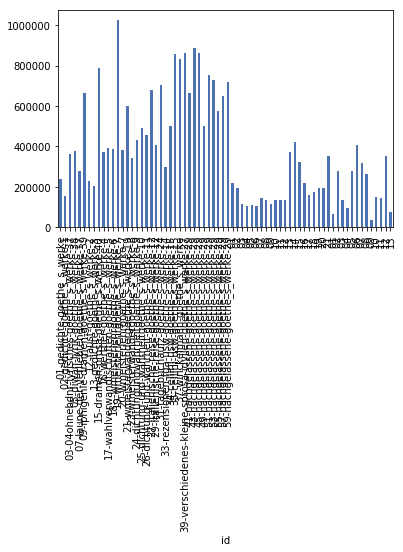

In [43]:
src = load_folder('data/source', size=None)
src.text.str.len().plot('bar')

### Target data (to verify)

In [44]:
target = load_folder('data/target', size=None, ext='.txt')
target

,title,author,text
id,,,
herder_01,herder_01,fga,Frankfurt am Nava Js D Michaelis Mosaifches Re...
herder_02,herder_02,fga,L e ip zi g Seaatoveeonderungen von Italien in...
herder_03,herder_03,fga,Gottingen nnd Gruben eLL S lo ers Vorstellung ...
herder_04,herder_04,fga,Helle D Fel xswleyi Psksplrrnlie Evangelii Joh...
herder_05,herder_05,fga,Gottingen und Gema I D Michaclis Verfuch uber ...
herder_06,herder_06,fga,Leipzig dklnekktmgm ahek den Unterschied der S...
herder_07,herder_07,fga,Koprnhngen und Leipzig Ismes Beattie Vecfuch T...
unverified_clean_01,unverified_clean_01,fga,Danzig Cymbelline ein Trauerspiel nach einem v...
unverified_clean_02,unverified_clean_02,fga,Wittenberg und Zerbst Empfindsame Reisen durch...


Min len: 2102
Max len: 12865
Mean len: 7106.86666667


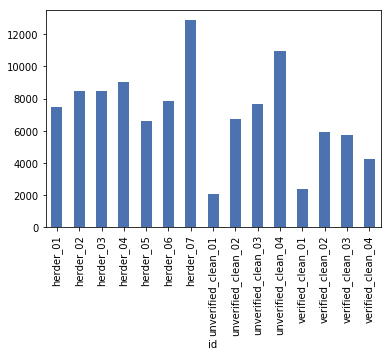

In [45]:
target['length'] = target.text.str.len()
target.length.plot('bar')
print('Min len:', target.length.min())
print('Max len:', target.length.max())
print('Mean len:', target.length.mean())

In [46]:
SIZE = int(target.length.min())
source = load_folder('data/source', ext='.txt', size=SIZE)
target = load_folder('data/target', ext='.txt', size=None)

In [47]:
source.head()

,title,author,text
id,,,
01-gedichte-goethe_s_werke_1,01-gedichte-goethe_s_werke,goethe,Zueignung Werk I Der Morgen kam es scheuchten ...
01-gedichte-goethe_s_werke_2,01-gedichte-goethe_s_werke,goethe,ft genannt und jeder heisst dich sein Sin jede...
01-gedichte-goethe_s_werke_3,01-gedichte-goethe_s_werke,goethe,zgeruch uro Di fk Ss schweigt das Wehen banger...
01-gedichte-goethe_s_werke_4,01-gedichte-goethe_s_werke,goethe,Fuchs so gilt der Balg Nach Mittage sassen wi...
01-gedichte-goethe_s_werke_5,01-gedichte-goethe_s_werke,goethe,uf Ist eine die so lieben Mund Liebrunde Wanql...


In [48]:
target.head()

,title,author,text
id,,,
herder_01,herder_01,fga,Frankfurt am Nava Js D Michaelis Mosaifches Re...
herder_02,herder_02,fga,L e ip zi g Seaatoveeonderungen von Italien in...
herder_03,herder_03,fga,Gottingen nnd Gruben eLL S lo ers Vorstellung ...
herder_04,herder_04,fga,Helle D Fel xswleyi Psksplrrnlie Evangelii Joh...
herder_05,herder_05,fga,Gottingen und Gema I D Michaclis Verfuch uber ...


In [49]:
len(source)

12492

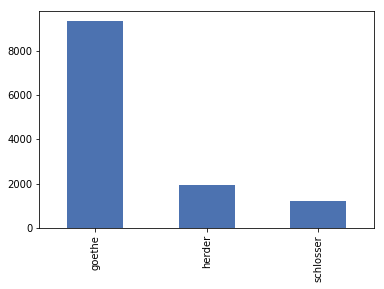

In [50]:
source.author.value_counts().plot('bar')

# Restrict Goethe samples

### Vectorization

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# set vectorization params:
p_char = {'use_idf': True,
     'max_features': 10000,
     'analyzer': 'char',
     'min_df': 2,
     'lowercase': True,
     'norm': 'l1',
     'ngram_range': (4, 4)}

p_word = {'use_idf': True,
     'max_features': 50000,
     'analyzer': 'word',
     'min_df': 2,
     'lowercase': True,
     'norm': 'l1',
     'ngram_range': (1, 2)}

In [52]:
goethe_samples = source[source.author == 'goethe']
print(len(goethe_samples))
goethe_samples.head()

9333


,title,author,text
id,,,
01-gedichte-goethe_s_werke_1,01-gedichte-goethe_s_werke,goethe,Zueignung Werk I Der Morgen kam es scheuchten ...
01-gedichte-goethe_s_werke_2,01-gedichte-goethe_s_werke,goethe,ft genannt und jeder heisst dich sein Sin jede...
01-gedichte-goethe_s_werke_3,01-gedichte-goethe_s_werke,goethe,zgeruch uro Di fk Ss schweigt das Wehen banger...
01-gedichte-goethe_s_werke_4,01-gedichte-goethe_s_werke,goethe,Fuchs so gilt der Balg Nach Mittage sassen wi...
01-gedichte-goethe_s_werke_5,01-gedichte-goethe_s_werke,goethe,uf Ist eine die so lieben Mund Liebrunde Wanql...


In [53]:
non_goethe_samples = source[source.author != 'goethe']
print(len(non_goethe_samples))

3159


In [54]:
vectorizer = TfidfVectorizer(**p_char)
non_goethe_X = vectorizer.fit_transform(non_goethe_samples.text).toarray()
goethe_X = vectorizer.transform(goethe_samples.text).toarray()

print(goethe_X.shape)
print(non_goethe_X.shape)

(9333, 10000)
(3159, 10000)


In [55]:
centroid = np.mean(non_goethe_X, axis=0)

In [56]:
from scipy.spatial.distance import cdist, pdist
dists = cdist(goethe_X, [centroid], 'cosine').ravel()
print(dists.shape)

(9333,)


In [57]:
nb_samples = len(non_goethe_samples)
nn_idxs = dists.argsort()[:nb_samples]

In [58]:
restricted_goethe_samples = goethe_samples.ix[nn_idxs, :]
restricted_goethe_samples.head()

,title,author,text
id,,,
25-dichtung-und-wahrheitgoethe_s_werke-10_139,25-dichtung-und-wahrheitgoethe_s_werke-10,goethe,n werden in ihm erregt und entwickelt werden B...
15-dramen-prosa-goethe_s_werke-40_237,15-dramen-prosa-goethe_s_werke-40,goethe,ust ersetzen konnten sie fuhlt sich allein ver...
16-werther-goethe_s_werke-4_55,16-werther-goethe_s_werke-4,goethe,ante in ihrem Alter Mangel an allem kein ansta...
24-dichtungundwahrheitgoethe_s_werke-9_66,24-dichtungundwahrheitgoethe_s_werke-9,goethe,uck und ich konnte nicht unterlassen die sammt...
17-wahlverwandtschaften-goethe_s_werke-5_108,17-wahlverwandtschaften-goethe_s_werke-5,goethe,rucken da wir weder reich noch heiter genug si...


In [59]:
df = pd.concat((restricted_goethe_samples, non_goethe_samples))
df.head()

,title,author,text
id,,,
25-dichtung-und-wahrheitgoethe_s_werke-10_139,25-dichtung-und-wahrheitgoethe_s_werke-10,goethe,n werden in ihm erregt und entwickelt werden B...
15-dramen-prosa-goethe_s_werke-40_237,15-dramen-prosa-goethe_s_werke-40,goethe,ust ersetzen konnten sie fuhlt sich allein ver...
16-werther-goethe_s_werke-4_55,16-werther-goethe_s_werke-4,goethe,ante in ihrem Alter Mangel an allem kein ansta...
24-dichtungundwahrheitgoethe_s_werke-9_66,24-dichtungundwahrheitgoethe_s_werke-9,goethe,uck und ich konnte nicht unterlassen die sammt...
17-wahlverwandtschaften-goethe_s_werke-5_108,17-wahlverwandtschaften-goethe_s_werke-5,goethe,rucken da wir weder reich noch heiter genug si...


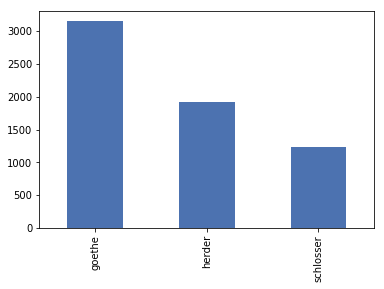

In [60]:
df.author.value_counts().plot('bar')

In [61]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(df.author)
print(y.shape)

(6318,)


In [62]:
vectorizer = TfidfVectorizer(**p_char)
X = vectorizer.fit_transform(df.text).toarray()

In [63]:
from sklearn.model_selection import train_test_split

train_X, dev_X, train_y, dev_y = train_test_split(X, y, test_size=.2, random_state=42)
print(train_X.shape)
print(dev_X.shape)
print(train_y.shape)
print(dev_y.shape)

(5054, 10000)
(1264, 10000)
(5054,)
(1264,)


In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
dev_X = scaler.transform(dev_X)
print(train_X.shape)
print(dev_X.shape)

(5054, 10000)
(1264, 10000)


## Verification

In [65]:
from knn import KNN

Simple feature dropout:

In [66]:
def dropout(X1, X2, p=.5):
    n = X1.shape[1]
    idxs = np.random.choice(n, int(n * p), replace=False)
    return X1[:, idxs], X2[:, idxs]

In [67]:
def imposters(X, y, n=30):
    nb = X.shape[0]
    idxs = np.random.choice(nb, n, replace=False)
    return X[idxs, :], y[idxs]

In [71]:
from distance_metrics import pairwise_minmax as minmax

In [72]:
METRICS = {'cosine': 'cosine',
           'minmax': minmax}

In [73]:
from sklearn.neighbors import NearestCentroid
from sklearn.preprocessing import normalize
import random

class Verifier(object):
    def __init__(self, iters=100, base='profile',
                 rnd_prop=.5, random_state=1066,
                 nb_imposters=30, metric='cosine',
                 rnd_state=1234):
        assert base in ('profile', 'instance')
        assert metric in METRICS
        assert (rnd_prop >= 0.0) and (rnd_prop <= 1.0)
        
        np.random.seed(rnd_state)
        self.metric = METRICS[metric]
        self.iters = iters
        self.base = base
        self.rnd_prop = rnd_prop
        self.nb_imposters = nb_imposters
    
    def fit(self, X, y):
        if self.base == 'profile':
            self.train_X = NearestCentroid().fit(X, y).centroids_
            self.train_y = np.array(range(self.train_X.shape[0]))
            
        elif self.base == 'instance':
            self.train_X = X.copy()
            self.train_y = y.copy()
        
        self.nb_classes_ = len(set(y))
    
    def predict(self, X, target=-1):
        preds = self.predict_proba(X, target=target)
        return np.argmax(preds, axis=1)
    
    def predict_proba(self, X, target=-1):
        nb = X.shape[0]
        probas = np.zeros((nb, self.nb_classes_))
        
        if target > -1:
            targets = self.train_y == target
            target_X = self.train_X[targets]
            target_y = self.train_y[targets]
            
            non_targets = self.train_y != target
            non_target_X = self.train_X[non_targets]
            non_target_y = self.train_y[non_targets]
            
        for it in range(self.iters):
            if it and (it % 25) == 0:
                print(f'-> iter {it}')
                
            if target > -1:
                # sample imposters
                imposter_X, imposter_y = imposters(non_target_X, non_target_y,
                                                   n=self.nb_imposters)
                target_X_, target_y_ = imposters(target_X, target_y,
                                                   n=self.nb_imposters)
                
                train_X_ = np.vstack((target_X_, imposter_X))
                train_y_ = np.hstack((target_y_, imposter_y))
            else:
                train_X_ = self.train_X
                train_y_ = self.train_y
            
            # apply dropout:
            train_X_, X_ = dropout(train_X_, X, p=self.rnd_prop)
            
            # fit simple knn:
            knn = KNN(k=1, metric=self.metric)
            knn.fit(train_X_, train_y_)
            pred = np.array(knn.predict(X_))
            probas[np.arange(nb), pred] += 1
            
        probas = normalize(probas, norm='l1')    
        return probas

Simple attribution on dev set: no dropout, no imposters:

In [74]:
verifier = Verifier(iters=1, base='instance',
                    rnd_prop=1.)
verifier.fit(train_X, train_y)
preds = verifier.predict(dev_X)

import sklearn.metrics as metrics
print(f'Accuracy: {metrics.accuracy_score(preds, dev_y)}')
print(f'F1-score: {metrics.f1_score(preds, dev_y, average="macro")}')

Accuracy: 0.9248417721518988
F1-score: 0.9234183032029625


In [75]:
verifier = Verifier(iters=250, base='instance',
                    rnd_prop=.5)
verifier.fit(train_X, train_y)
preds = verifier.predict(dev_X, target=-1)
print(f'Accuracy: {metrics.accuracy_score(preds, dev_y)}')
print(f'F1-score: {metrics.f1_score(preds, dev_y, average="macro")}')

-> iter 25
-> iter 50
-> iter 75
-> iter 100
-> iter 125
-> iter 150
-> iter 175
-> iter 200
-> iter 225
Accuracy: 0.9501582278481012
F1-score: 0.9477346256684491


In [76]:
verifier = Verifier(iters=250, base='instance',
                    rnd_prop=.5, nb_imposters=100)
verifier.fit(train_X, train_y)

target_idx = list(encoder.classes_).index('goethe')
preds = verifier.predict(dev_X, target=target_idx)

print(f'Accuracy: {metrics.accuracy_score(preds, dev_y)}')
print(f'F1-score: {metrics.f1_score(preds, dev_y, average="macro")}')

-> iter 25
-> iter 50
-> iter 75
-> iter 100
-> iter 125
-> iter 150
-> iter 175
-> iter 200
-> iter 225
Accuracy: 0.9802215189873418
F1-score: 0.9783694241528531


In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from itertools import product

def plot_confusion_matrix(cm, target_names,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tick_params(labelsize=6)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.plot()

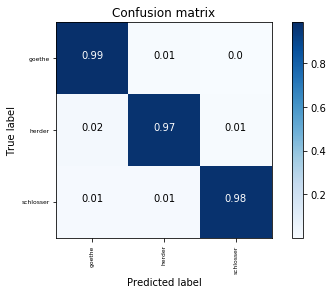

In [78]:
T = encoder.inverse_transform(dev_y)
P = encoder.inverse_transform(preds)
cm = confusion_matrix(T, P, labels=encoder.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_normalized, target_names=encoder.classes_)

## Test data

In [79]:
from itertools import product

def heat(test_probas, candidates, titles):
    fig = plt.figure(figsize=(10, 20))
    plt.imshow(test_probas, interpolation='nearest', cmap=plt.cm.Reds,
              aspect='auto')
    plt.tick_params(labelsize=6)
    plt.title('Verification probabilities')
    plt.colorbar()
    tick_marks = np.arange(len(candidates))
    plt.xticks(tick_marks, candidates, rotation=90, fontsize=14)
    tick_marks = np.arange(len(titles))
    plt.yticks(tick_marks, titles, fontsize=14)
    thresh = test_probas.max() / 2.
    for i, j in product(range(test_probas.shape[0]), range(test_probas.shape[1])):
        plt.text(j, i, round(test_probas[i, j], 2),
                 horizontalalignment="center",
                 color="white" if test_probas[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Title')
    plt.xlabel('Candidate')
    plt.plot()

In [80]:
test_X = vectorizer.transform(target.text).toarray()
test_X = scaler.transform(test_X)

-> iter 25
-> iter 50
-> iter 75
-> iter 100
-> iter 125
-> iter 150
-> iter 175
-> iter 200
-> iter 225
(15, 2)


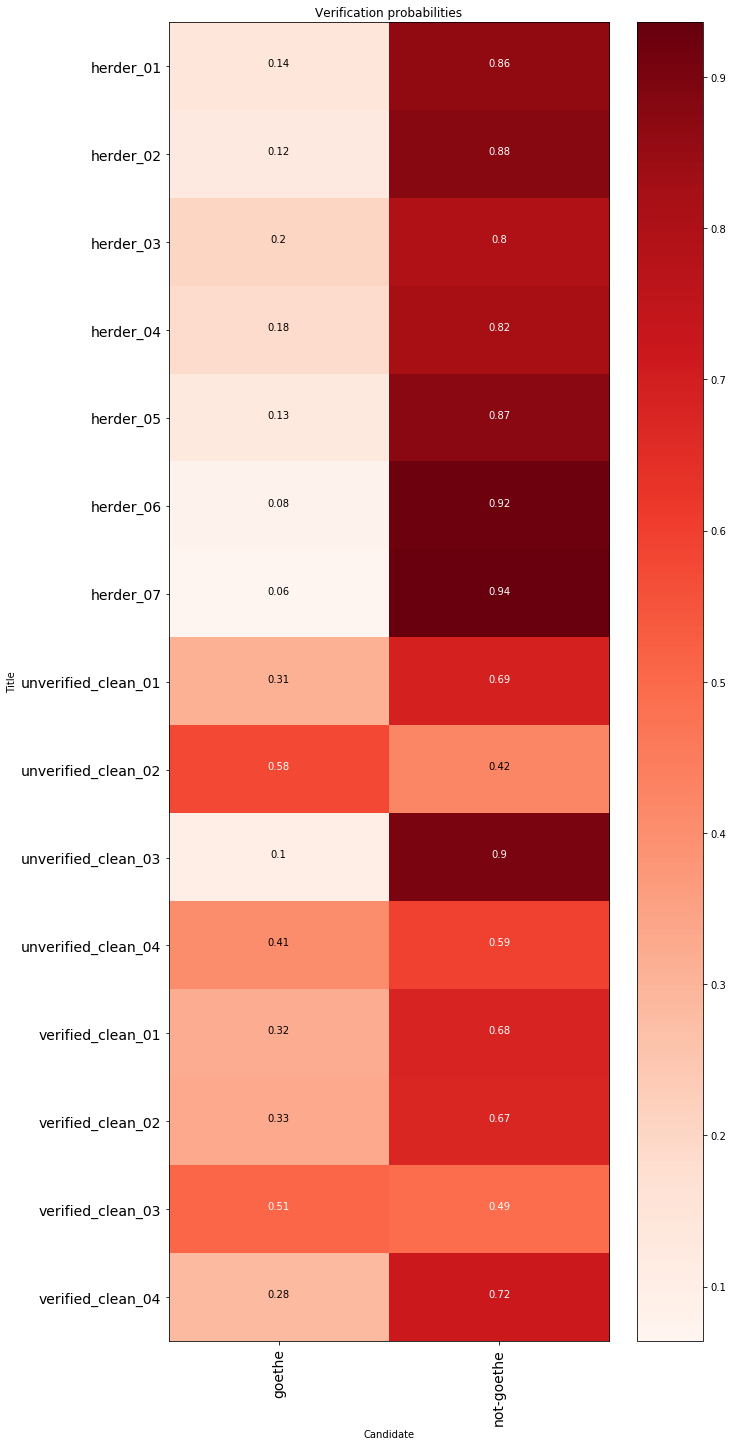

In [82]:
verifier = Verifier(iters=250, base='instance',
                    rnd_prop=.5, nb_imposters=100)
verifier.fit(train_X, train_y)
test_probas = verifier.predict_proba(test_X, target=target_idx)
final = np.zeros((test_probas.shape[0], 2))
final[:, 0] = test_probas[:, 0]
final[:, 1] = test_probas[:, 1] + test_probas[:, 2]
print(final.shape)
heat(final, ['goethe', 'not-goethe'], target.title)

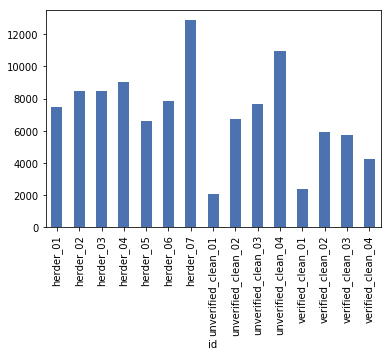

In [83]:
target['length'] = target.text.str.len()
target.length.plot('bar')

## Craig's Zeta

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

# set vectorization params:
zeta_p = {'binary': True,
          'max_features': 10000,
          'analyzer': 'word',
          'min_df': 2}

T = tuple(df.text[df.author == 'goethe'])
C = tuple(df.text[df.author != 'goethe'])
zeta_vec = CountVectorizer(**zeta_p).fit(T + C)
T = zeta_vec.transform(T).toarray()
C = zeta_vec.transform(C).toarray()

In [85]:
n_T = T.shape[0]
n_C = C.shape[0]
print(f'Number of Goethe: {n_T}')
print(f'Number of others: {n_C}')

Number of Goethe: 3159
Number of others: 3159


In [86]:
dp_T = T.sum(axis=0) / n_T
dp_C = C.sum(axis=0) / n_C

In [87]:
Z = dp_T - dp_C

In [88]:
zeta_vocab = zeta_vec.get_feature_names()
ranked = [(zeta_vocab[idx], Z[idx]) for idx in np.argsort(Z)]

In [89]:
print('-> words under-used by Goethe:')
for i in range(25):
    w, s = ranked[i]
    print(f'   {w} {s:{0}.{3}}')

print('=' * 20)

print('-> words over-used by Goethe:')
for i in range(25):
    w, s = ranked[-i-1]
    print(f'   {w} {s:{0}.{3}}')

-> words under-used by Goethe:
   also -0.341
   oder -0.233
   dies -0.219
   bey -0.202
   blos -0.187
   hat -0.18
   kein -0.153
   wer -0.14
   andre -0.138
   unsrer -0.135
   sei -0.128
   seele -0.127
   anders -0.126
   kann -0.121
   dunkt -0.119
   unsre -0.118
   ists -0.115
   du -0.114
   waldchen -0.11
   kritische -0.11
   alle -0.109
   de -0.109
   walder -0.109
   muss -0.107
   giebt -0.105
-> words over-used by Goethe:
   hatte 0.26
   bei 0.251
   mir 0.234
   war 0.231
   indem 0.213
   wieder 0.185
   besonders 0.182
   man 0.181
   schon 0.153
   sagte 0.15
   sich 0.149
   sehen 0.149
   sey 0.146
   mich 0.145
   doch 0.14
   meine 0.139
   schien 0.139
   wohl 0.136
   immer 0.136
   mochte 0.133
   wir 0.133
   einen 0.132
   durch 0.128
   wilhelm 0.123
   einem 0.121


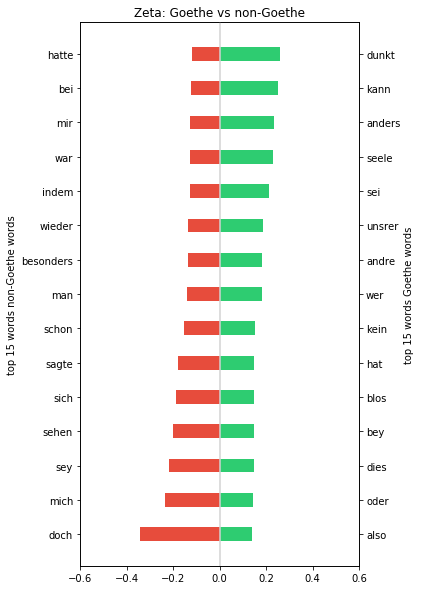

In [90]:
width = .4
m = 15
fig = plt.figure(figsize=(5, 10))

goe_labels, goe_scores = zip(*ranked[:m])
non_labels, non_scores = zip(*ranked[-m:])
pos = np.arange(m) - (width / 2)

ax1 = fig.add_subplot(111)
plt.barh(pos, goe_scores, width, label='Goethe', color="#e74c3c")

plt.yticks(pos, non_labels)
ax1.set_ylabel(f'top {m} words non-Goethe words')

ax2 = ax1.twinx()
ax2.barh(pos, non_scores, width, label='non-Goethe', color='#2ecc71')
ax2.set_yticks(pos)
ax2.set_yticklabels(goe_labels)

plt.xlim((-.6, +.6))
plt.axvline(0, color='lightgrey')
ax2.set_ylabel(f'top {m} words Goethe words')
plt.xlabel('Zeta scores')
plt.title(f'Zeta: Goethe vs non-Goethe')